# EDA: Timeseries Analysis 

Use of basic and advanced techniques for timeseries analysis and prediction of crypto-currencies prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('../data/bitcoin_price.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Oct 03, 2017",4408.46,4432.47,4258.89,4317.48,"1,288,020,000","73,181,300,000"
1,"Oct 02, 2017",4395.81,4470.23,4377.46,4409.32,"1,431,730,000","72,963,200,000"
2,"Oct 01, 2017",4341.05,4403.74,4269.81,4403.74,"1,208,210,000","72,047,300,000"
3,"Sep 30, 2017",4166.11,4358.43,4160.86,4338.71,"1,207,450,000","69,136,600,000"
4,"Sep 29, 2017",4171.62,4214.63,4039.29,4163.07,"1,367,050,000","69,219,200,000"


In [3]:
data['Date']=pd.to_datetime(data['Date'], format='%b %d, %Y')
close_price = data[['Date','Close']]
close_price.index = close_price['Date']
close_price_ts=close_price['Close']

# chronological order
close_price_ts=close_price_ts.sort_index()
close_price_ts.head()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64

## Raw signal

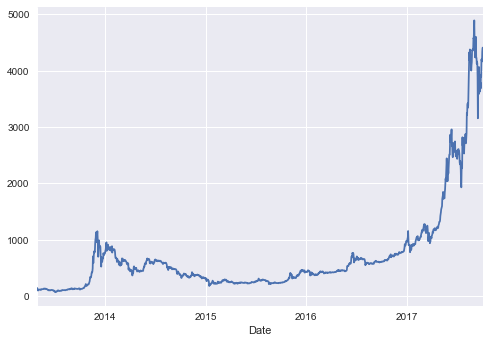

In [4]:
close_price_ts.plot()
plt.show()

## Do we have missing values?

In [5]:
nan_values=pd.isnull(close_price_ts)
nan_values[nan_values==True]

Series([], Name: Close, dtype: bool)

There are no values missing. Great news !

## Transformations of the signal

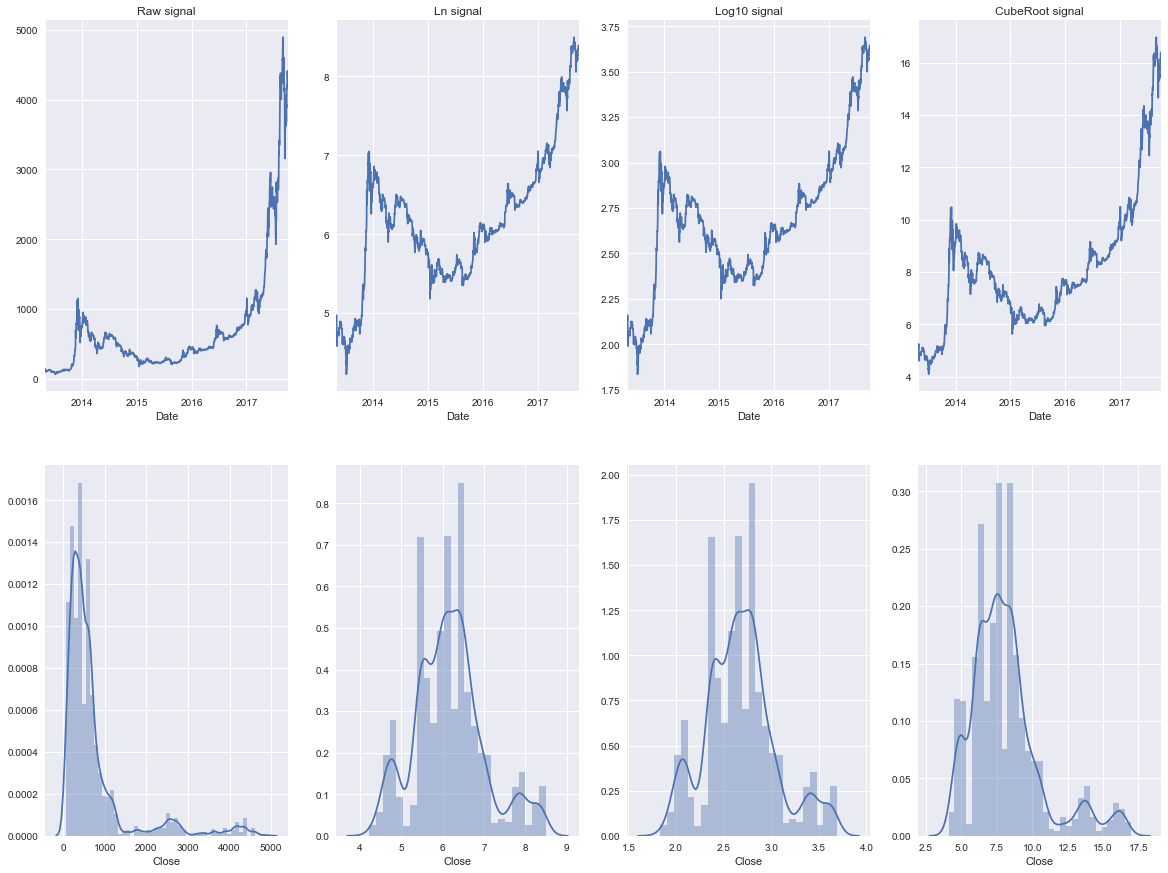

In [6]:
close_price_ts_ln = close_price_ts.apply(lambda x: np.log(x))
close_price_ts_log = close_price_ts.apply(lambda x: np.log10(x))
close_price_ts_cuberoot = close_price_ts.apply(lambda x: x**(1./3.))

plt.figure(figsize=(20,15))

plt.subplot(2,4,1)
close_price_ts.plot()
plt.title('Raw signal')

plt.subplot(2,4,2)
close_price_ts_ln.plot()
plt.title('Ln signal')

plt.subplot(2,4,3)
close_price_ts_log.plot()
plt.title('Log10 signal')

plt.subplot(2,4,4)
close_price_ts_cuberoot.plot()
plt.title('CubeRoot signal')

plt.subplot(2,4,5)
sns.distplot(close_price_ts)

plt.subplot(2,4,6)
sns.distplot(close_price_ts_ln)

plt.subplot(2,4,7)
sns.distplot(close_price_ts_log)

plt.subplot(2,4,8)
sns.distplot(close_price_ts_cuberoot)


plt.show()

## Time lag

The idea here is to see if there is a relationship between time lags

In [7]:
print(close_price_ts.shift(0).head())
print()
print(close_price_ts.shift(1).head())
print()
print(close_price_ts.shift(2).head())
print()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64

Date
2013-04-28       NaN
2013-04-29    134.21
2013-04-30    144.54
2013-05-01    139.00
2013-05-02    116.99
Name: Close, dtype: float64

Date
2013-04-28       NaN
2013-04-29       NaN
2013-04-30    134.21
2013-05-01    144.54
2013-05-02    139.00
Name: Close, dtype: float64



In [20]:
lagmax=30
all_lags = list(range(1,lagmax+1))

lagged_data = pd.concat([close_price_ts]+[close_price_ts.shift(i) for i in all_lags],axis=1,
                       keys=['original']+['Lag%d' % j for j in all_lags]).dropna()
lagged_data.head()

,original,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,...,Lag21,Lag22,Lag23,Lag24,Lag25,Lag26,Lag27,Lag28,Lag29,Lag30
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-28,129.0,129.75,133.48,131.98,133.20,126.70,123.89,122.88,122.00,121.99,...,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00,144.54,134.21
2013-05-29,132.3,129.00,129.75,133.48,131.98,133.20,126.70,123.89,122.88,122.00,...,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00,144.54
2013-05-30,128.8,132.30,129.00,129.75,133.48,131.98,133.20,126.70,123.89,122.88,...,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99,139.00
2013-05-31,129.0,128.80,132.30,129.00,129.75,133.48,131.98,133.20,126.70,123.89,...,117.20,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21,116.99
2013-06-01,129.3,129.00,128.80,132.30,129.00,129.75,133.48,131.98,133.20,126.70,...,115.24,117.20,112.67,113.57,111.50,112.30,115.91,112.50,97.75,105.21


### Model the lags

In [38]:
import statsmodels.formula.api as smf
formula = 'original ~ trend'
for i in all_lags:
    formula = formula + ' + Lag%i'%i
model_lagged=smf.ols(formula, data=lagged_data.assign(trend=np.arange(len(lagged_data))))

res_lagged = model_lagged.fit()
print(res_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:               original   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Sun, 22 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:02:21   Log-Likelihood:                -8476.2
No. Observations:                1590   AIC:                         1.702e+04
Df Residuals:                    1558   BIC:                         1.719e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3320      2.561     -1.301      0.1

[  9.47884597e-01   4.89316719e-02   2.55860282e-02  -5.21752965e-02
   8.13146453e-02  -1.61983959e-02  -5.35620746e-02  -1.78615518e-02
   5.47165427e-02   1.00928402e-02   8.36980945e-03   9.03769863e-02
  -2.26029223e-01   1.00925423e-01   1.96702896e-03  -4.61678045e-04
   6.76173961e-02   1.26029796e-02  -5.61767498e-02  -2.15373033e-02
  -1.85551787e-01   1.96528576e-01  -1.47281977e-01   1.81485805e-01
   6.58915219e-02  -1.58863525e-01   1.63223833e-01  -3.21677862e-01
   3.43532022e-02   1.72171313e-01]
-1.30841262997


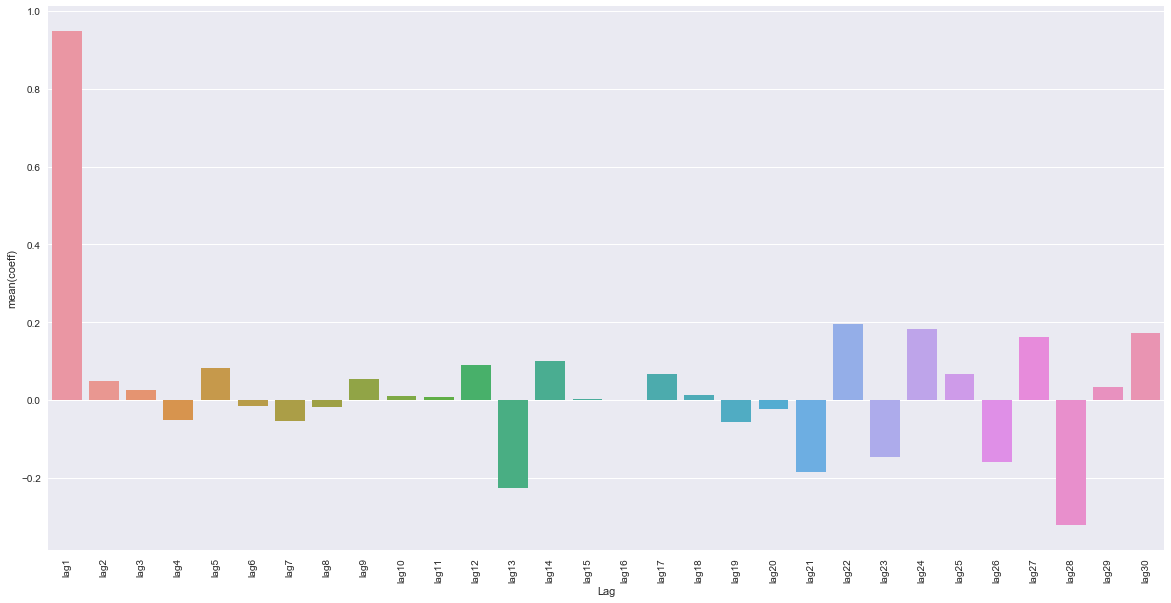

In [32]:
from sklearn.linear_model import LinearRegression
y = lagged_data['original'].values
X = lagged_data.drop('original',1).values

ols = LinearRegression()
ols.fit(X,y)
print(ols.coef_)
print(ols.intercept_)
ols_coefs_per_lag=pd.DataFrame({'Lag':['lag%d' %i for i in all_lags],'coeff':ols.coef_})

plt.figure(figsize=(20,10))
lag_coeff_barplot=sns.barplot(x='Lag',y='coeff',data=ols_coefs_per_lag)
for item in lag_coeff_barplot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### Correlation between the lags

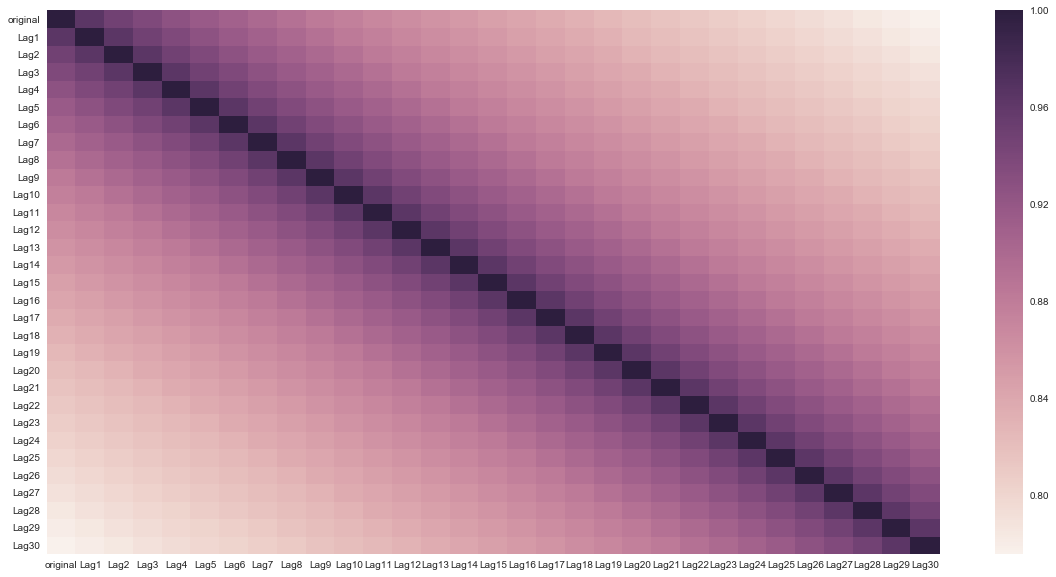

In [36]:
plt.figure(figsize=(20,10))
sns.heatmap(lagged_data.corr(method='kendall'))
plt.show()